# GoogleNet implementation

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
import os

## Import data

In [ ]:
dataset_path = "/content/drive/MyDrive/Project dataset/chest X ray subsets.zip"

In [ ]:
import zipfile

# Unzip the file
zip_ref = zipfile.ZipFile(dataset_path)
zip_ref.extractall()
zip_ref.close()

In [ ]:
pip install split-folders

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
def split_folders():
  splitfolders.ratio(input=input_folder, output=output_folder,
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

In [ ]:
# Dataset 1

input_folder = "/content/chest X ray subsets/Dataset 1"
os.mkdir("/content/chest X ray subsets/Dataset 1_split")
output_folder = "/content/chest X ray subsets/Dataset 1_split"

split_folders()

Copying files: 1124 files [00:00, 4402.52 files/s]


In [ ]:
# Dataset 2

input_folder = "/content/chest X ray subsets/Dataset 2"
os.mkdir("/content/chest X ray subsets/Dataset 2_split")
output_folder = "/content/chest X ray subsets/Dataset 2_split"

split_folders()

Copying files: 13808 files [00:04, 3038.29 files/s]


In [ ]:
# Dataset 3

input_folder = "/content/chest X ray subsets/Dataset 3"
os.mkdir("/content/chest X ray subsets/Dataset 3_split")
output_folder = "/content/chest X ray subsets/Dataset 3_split"

split_folders()

Copying files: 15153 files [00:04, 3580.62 files/s]


In [ ]:
# Setup the train and test directories for dataset 1

train_dir_dataset_1 = "/content/chest X ray subsets/Dataset 1_split/train/"
test_dir_dataset_1 = "/content/chest X ray subsets/Dataset 1_split/val/"

In [ ]:
# Setup the train and test directories for dataset 2

train_dir_dataset_2 = "/content/chest X ray subsets/Dataset 2_split/train/"
test_dir_dataset_2 = "/content/chest X ray subsets/Dataset 2_split/val/"

In [ ]:
# Setup the train and test directories for dataset 3

train_dir_dataset_3 = "/content/chest X ray subsets/Dataset 3_split/train/"
test_dir_dataset_3 = "/content/chest X ray subsets/Dataset 3_split/val/"

In [ ]:
# Let's get the class names

# Change accordingly
train_dir = train_dir_dataset_3

import pathlib
import numpy as np
dir_path = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in dir_path.glob('*')]))
class_names

array(['Covid-19', 'Healthy', 'Viral Pneumonia'], dtype='<U15')

## Data preparation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# From ImageDataGenerator, we are preprocessing and augmenting our data
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   )
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Change accordingly
train_dir = train_dir_dataset_3
test_dir = test_dir_dataset_3

In [ ]:
# From flow_from_directory, we are loading images into data loaders

img_width = 224
img_height = 224
batch_size = 32

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(img_width, img_height),
                                               batch_size=batch_size,
                                               #class_mode="binary",
                                               class_mode="categorical",
                                
                                               color_mode='grayscale',
                                               shuffle=True)  # shuffling between normal and covid

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             #class_mode="binary",
                                             class_mode="categorical",
                                             color_mode='grayscale',
                                             shuffle=False)   # No need to shuffle data

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [ ]:
# Dataset 1

len(train_data), len(test_data)

(29, 8)

In [ ]:
# Dataset 2

len(train_data), len(test_data)

(346, 87)

In [ ]:
# Dataset 3

len(train_data), len(test_data)

(379, 95)

## Model implementation

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
# GoogleNet for binary classification

def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)


   # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)

  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
# GoogleNet for multiclass classification

def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(3, activation = 'sigmoid')(X1)


   # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(3, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(3, activation = 'sigmoid')(X)

  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
model = GoogLeNet()

In [ ]:
# GoogleNet binary classification model's summary
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

In [ ]:
# GoogleNet multiclass classification model's summary
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 109, 109, 64  3200        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_118[0][0]']             
 )                                                                                        

In [ ]:
# For binary Classification

optimizer = tf.keras.optimizers.Adam()

model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# For multiclass classification

optimizer = tf.keras.optimizers.Adam()

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Dataset 1

# Fit the model
epochs = 20

import time
start = time.time()


history_google_1 = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

end = time.time()
print("Total training time for ", epochs, " epochs: " , round(end - start), "seconds/", round((end - start)/60) , " minutes")

Epoch 1/20
29/29 [==============================] - 31s 442ms/step - loss: 1.9720 - dense_4_loss: 0.6591 - dense_1_loss: 0.6526 - dense_3_loss: 0.6603 - dense_4_accuracy: 0.6336 - dense_1_accuracy: 0.6448 - dense_3_accuracy: 0.6414 - val_loss: 1.7931 - val_dense_4_loss: 0.6015 - val_dense_1_loss: 0.5940 - val_dense_3_loss: 0.5976 - val_dense_4_accuracy: 0.6416 - val_dense_1_accuracy: 0.6416 - val_dense_3_accuracy: 0.6416
Epoch 2/20
29/29 [==============================] - 10s 327ms/step - loss: 1.8073 - dense_4_loss: 0.6284 - dense_1_loss: 0.5767 - dense_3_loss: 0.6022 - dense_4_accuracy: 0.6548 - dense_1_accuracy: 0.6993 - dense_3_accuracy: 0.6414 - val_loss: 1.6540 - val_dense_4_loss: 0.5698 - val_dense_1_loss: 0.5729 - val_dense_3_loss: 0.5113 - val_dense_4_accuracy: 0.6416 - val_dense_1_accuracy: 0.7965 - val_dense_3_accuracy: 0.6416
Epoch 3/20
29/29 [==============================] - 10s 327ms/step - loss: 1.5050 - dense_4_loss: 0.5150 - dense_1_loss: 0.4947 - dense_3_loss: 0.4953

In [ ]:
# Dataset 2

# Fit the model
epochs = 20

import time
start = time.time()


history_google_1 = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

end = time.time()
print("Total training time for ", epochs, " epochs: " , round(end - start), "seconds/", round((end - start)/60) , " minutes")

Epoch 1/20
346/346 [==============================] - 124s 339ms/step - loss: 1.5807 - dense_9_loss: 0.5292 - dense_6_loss: 0.5243 - dense_8_loss: 0.5272 - dense_9_accuracy: 0.7497 - dense_6_accuracy: 0.7463 - dense_8_accuracy: 0.7421 - val_loss: 1.4273 - val_dense_9_loss: 0.4748 - val_dense_6_loss: 0.4743 - val_dense_8_loss: 0.4781 - val_dense_9_accuracy: 0.7561 - val_dense_6_accuracy: 0.7278 - val_dense_8_accuracy: 0.7586
Epoch 2/20
346/346 [==============================] - 112s 324ms/step - loss: 1.2679 - dense_9_loss: 0.4244 - dense_6_loss: 0.4168 - dense_8_loss: 0.4267 - dense_9_accuracy: 0.8038 - dense_6_accuracy: 0.8080 - dense_8_accuracy: 0.8047 - val_loss: 0.9901 - val_dense_9_loss: 0.3409 - val_dense_6_loss: 0.3190 - val_dense_8_loss: 0.3302 - val_dense_9_accuracy: 0.8560 - val_dense_6_accuracy: 0.8657 - val_dense_8_accuracy: 0.8661
Epoch 3/20
346/346 [==============================] - 112s 323ms/step - loss: 1.1533 - dense_9_loss: 0.3877 - dense_6_loss: 0.3779 - dense_8_los

In [ ]:
# Dataset 3

# Fit the model
epochs = 20

import time
start = time.time()


history_google_3 = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

end = time.time()
print("Total training time for ", epochs, " epochs: " , round(end - start), "seconds/", round((end - start)/60) , " minutes")

Epoch 1/20
379/379 [==============================] - 134s 340ms/step - loss: 2.1551 - dense_14_loss: 0.7337 - dense_11_loss: 0.7032 - dense_13_loss: 0.7182 - dense_14_accuracy: 0.6773 - dense_11_accuracy: 0.6883 - dense_13_accuracy: 0.6829 - val_loss: 1.7374 - val_dense_14_loss: 0.6028 - val_dense_11_loss: 0.5551 - val_dense_13_loss: 0.5795 - val_dense_14_accuracy: 0.7068 - val_dense_11_accuracy: 0.7309 - val_dense_13_accuracy: 0.7236
Epoch 2/20
379/379 [==============================] - 123s 324ms/step - loss: 1.6504 - dense_14_loss: 0.5626 - dense_11_loss: 0.5352 - dense_13_loss: 0.5525 - dense_14_accuracy: 0.7438 - dense_11_accuracy: 0.7574 - dense_13_accuracy: 0.7489 - val_loss: 1.4555 - val_dense_14_loss: 0.4997 - val_dense_11_loss: 0.4613 - val_dense_13_loss: 0.4945 - val_dense_14_accuracy: 0.7737 - val_dense_11_accuracy: 0.7916 - val_dense_13_accuracy: 0.7734
Epoch 3/20
379/379 [==============================] - 123s 323ms/step - loss: 1.4005 - dense_14_loss: 0.4711 - dense_11_

## Saving the models (say for later use)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.

# change accordingly
#model.save('/content/GoogleNet_model_1.h5')
#model.save('/content/GoogleNet_model_2.h5')
model.save('/content/GoogleNet_model_3.h5')

## Model evaluation

In [ ]:
# Dataset 1

model.evaluate(test_data)

8/8 [==============================] - 1s 97ms/step - loss: 0.4636 - dense_4_loss: 0.1571 - dense_1_loss: 0.1514 - dense_3_loss: 0.1551 - dense_4_accuracy: 0.9558 - dense_1_accuracy: 0.9558 - dense_3_accuracy: 0.9558


[0.463643878698349,
 0.15712538361549377,
 0.15139508247375488,
 0.15512338280677795,
 0.9557521939277649,
 0.9557521939277649,
 0.9557521939277649]

In [ ]:
# Dataset 2

model.evaluate(test_data)

87/87 [==============================] - 9s 107ms/step - loss: 0.2966 - dense_9_loss: 0.0973 - dense_6_loss: 0.1036 - dense_8_loss: 0.0956 - dense_9_accuracy: 0.9653 - dense_6_accuracy: 0.9598 - dense_8_accuracy: 0.9667


[0.29655104875564575,
 0.09731955081224442,
 0.10358968377113342,
 0.09564179927110672,
 0.9652551412582397,
 0.9598262906074524,
 0.9667028784751892]

In [ ]:
# Dataset 3

model.evaluate(test_data)

95/95 [==============================] - 10s 109ms/step - loss: 0.4817 - dense_14_loss: 0.1653 - dense_11_loss: 0.1497 - dense_13_loss: 0.1667 - dense_14_accuracy: 0.9390 - dense_11_accuracy: 0.9512 - dense_13_accuracy: 0.9453


[0.481734961271286,
 0.16534370183944702,
 0.1497202217578888,
 0.1666710376739502,
 0.9389841556549072,
 0.9511873126029968,
 0.9452506303787231]

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  validation_loss = history.history["val_loss"]

  accuracy = history.history["dense_11_accuracy"]      # change accordingly
  validation_accuracy = history.history["val_dense_11_accuracy"]    # change accordingly

  # how many epochs did we run for?
  epochs = range(len(history.history["loss"]))
  
  # Plot loss
  plt.figure(figsize=(17, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="Training loss")
  plt.plot(epochs, validation_loss, label="Validation loss")
  plt.title("loss (training and testing)")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, validation_accuracy, label="Validation accuracy")
  plt.title("accuracy (training and testing)")
  plt.xlabel("epochs")
  plt.legend()

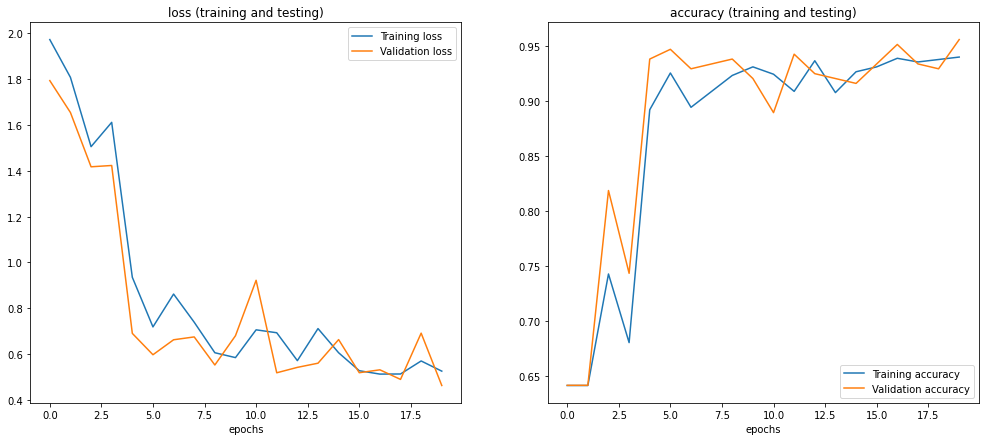

In [ ]:
# Dataset 1

plot_loss_curves(history=history_google_1)

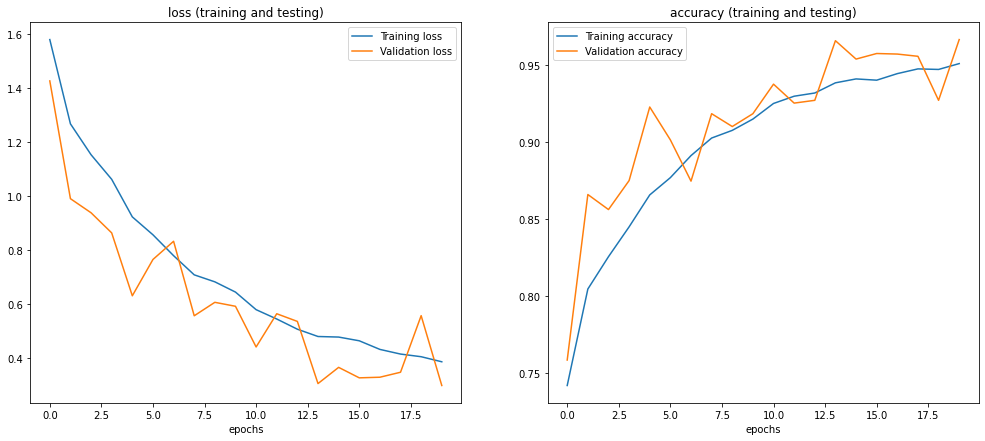

In [ ]:
# Dataset 2

plot_loss_curves(history=history_google_1)

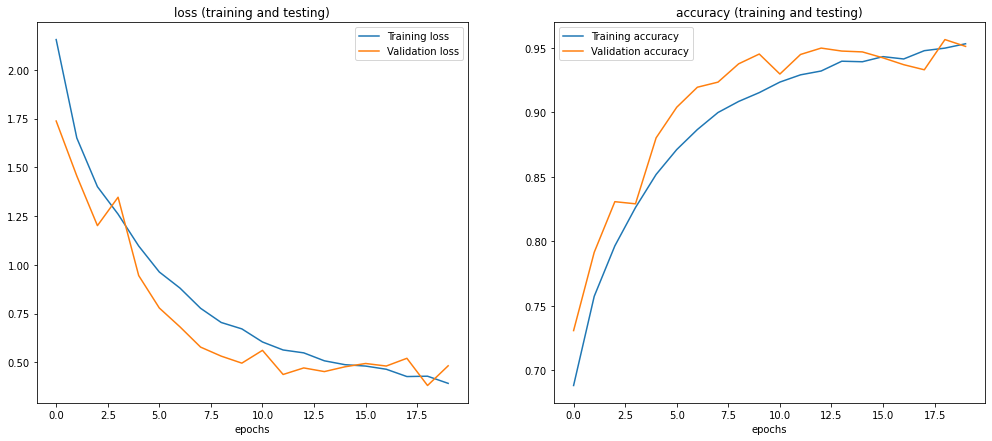

In [ ]:
# Dataset 3

plot_loss_curves(history=history_google_3)

## Prediction on custom image

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


def pred_and_plot(model, img_path):
  img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')
  
  # Preprocessing the image
  img = image.img_to_array(img)
  img = img/255
  img = np.expand_dims(img, axis=0)
  
  # predict image
  pred= model.predict(img)
  print(pred)              # let's see what actually pred is
  pred = pred[0]
  # prediction probabilty practice
  print('{:.2f}%'.format(max(pred[0])*100))


  # length of pred (which is 2D list)
  rows = len(pred)
  columns = len(pred[0])
  total_length = rows * columns
  print(total_length)
 
  # plot image
  plt.figure(figsize=(6,6))
  plt.axis('off')

  if total_length == 2:             # for binary classification
    pred_class = class_names[int(tf.round(pred))]
  else:
    if len(pred[0]) > 1:            # for multiclass classification
      pred_class = class_names[tf.argmax(pred[0])]
    else:
      pred_class = class_names[int(tf.round(pred[0]))]

 # if pred>= 0.5: 
  #    out = 'Normal case' #('I am {:.2%} percent confirmed that this is a Normal case'.format(pred[0][0]))
    
  #else: 
   #   out = 'Covid case' #('I am {:.2%} percent confirmed that this is a Covid case'.format(1-pred[0][0]))
  #print(format(pred[0][0]))
  plt.title("Chest X-Ray\n"+"Predicted label: "+ pred_class + " with prediction probabilty of " + '{:.2f}%'.format(max(pred[0])*100) +  "\nOriginal label: "+os.path.basename(img_path))  
  plt.imshow(np.squeeze(img))
  plt.show()

[array([[0.9978927]], dtype=float32), array([[0.99894553]], dtype=float32), array([[0.9980786]], dtype=float32)]
99.79%
1


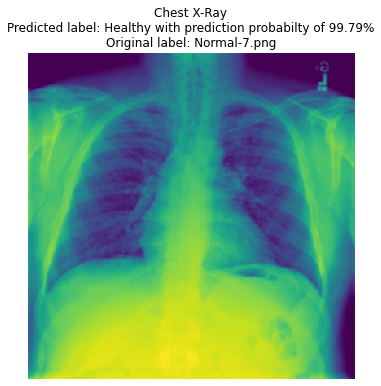

In [ ]:
pred_and_plot(model=model,
              img_path='/content/Normal-7.png')

[array([[0.02127284, 0.20196566, 0.978933  ]], dtype=float32), array([[0.00126207, 0.21936096, 0.9877302 ]], dtype=float32), array([[0.01208862, 0.11184515, 0.9816274 ]], dtype=float32)]
97.89%
3


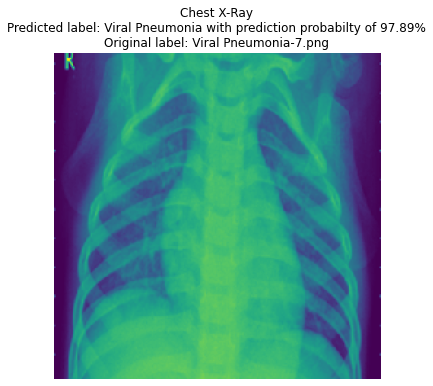

In [ ]:
pred_and_plot(model=model,
              img_path='/content/Viral Pneumonia-7.png')

In [ ]:
img_path = "/content/Normal-6.png"
img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')
  
# Preprocessing the image
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)
  
# predict image
pred= model.predict(img)
print(pred[0])
print(pred[1])
print(pred[2])

[[0.87513936 0.9748585  0.00185346]]
[[0.6630671  0.8685992  0.02377681]]
[[0.74506587 0.94133645 0.00254443]]


## Confusion matrix

In [ ]:
# Lets make function for y_preds
def model_pred(model):
  pred_probs = tf.round(model.predict(test_data))
  y_preds = tf.reshape(pred_probs, [-1])
  y_preds = np.array(y_preds).astype(int)
  value = int(y_preds.shape[0] / 3)
  return y_preds[:value]        # because GoogleNet gives 3X

In [ ]:
y_preds = model_pred(model = model)

In [ ]:
value = int(y_preds.shape[0] / 3)
value

921

In [ ]:
import math
n=32
number_of_examples = len(test_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * n)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data[i][1]))
  

test_labels = np.array(test_labels).astype(int)
test_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Dataset 2
test_labels.shape, y_preds.shape

((2763,), (2763,))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_preds)

array([[ 79,   2],
       [  8, 137]])

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

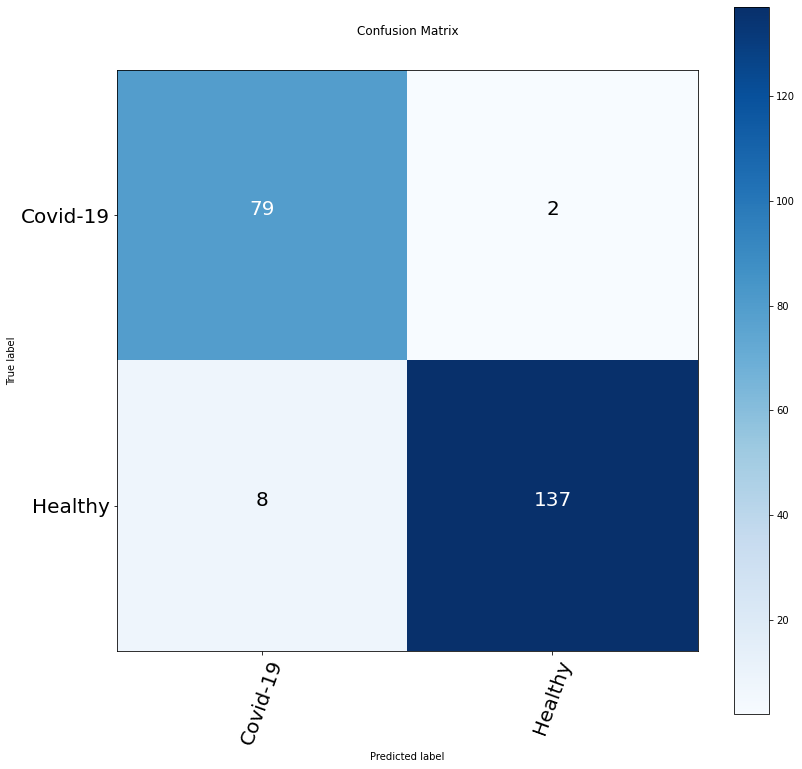

In [ ]:
# Plot a confusion matrix for dataset 1

make_confusion_matrix(y_true=test_labels,
                      y_pred=y_preds,
                      classes=['Covid-19', 'Healthy'],
                      figsize=(13, 13),
                      text_size=20,
                      norm=False,
                      savefig=True)

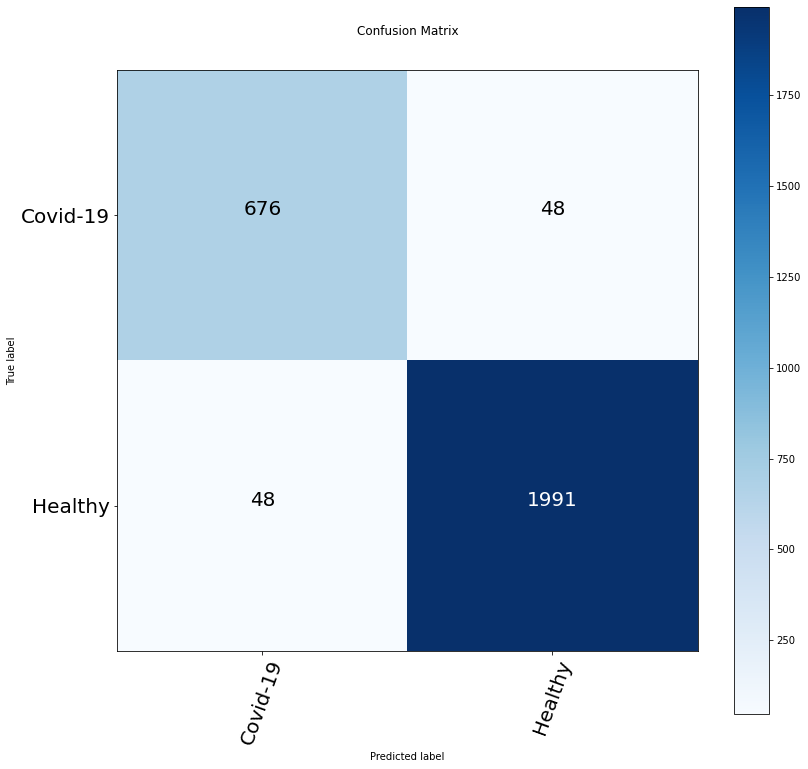

In [ ]:
# Plot a confusion matrix for dataset 2

make_confusion_matrix(y_true=test_labels,
                      y_pred=y_preds,
                      classes=['Covid-19', 'Healthy'],
                      figsize=(13, 13),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
# for dataset 1

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_preds))

# The classification_report() outputs the precision, recall and f1-score's per class.

# A reminder:

# Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
# Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
# F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst.

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        81
           1       0.95      0.94      0.95       145

    accuracy                           0.93       226
   macro avg       0.93      0.93      0.93       226
weighted avg       0.93      0.93      0.93       226



In [ ]:
# for dataset 2

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       724
           1       0.98      0.98      0.98      2039

    accuracy                           0.97      2763
   macro avg       0.96      0.96      0.96      2763
weighted avg       0.97      0.97      0.97      2763

